>>> Loading SHAP Data...
>>> Loading Heterogeneity Features...
    Features found: ['Stock', 'Daily_Price', 'Daily_Amplitude', 'Daily_Turnover', 'Daily_PE', 'Daily_FloatMV']
    Merged Samples: 9910

>>> Checking Factor: Daily_Amplitude ...
    Q1 (Low):  2024 | Max: 1.8135
    Q5 (High): 1951 | Min: 3.6380


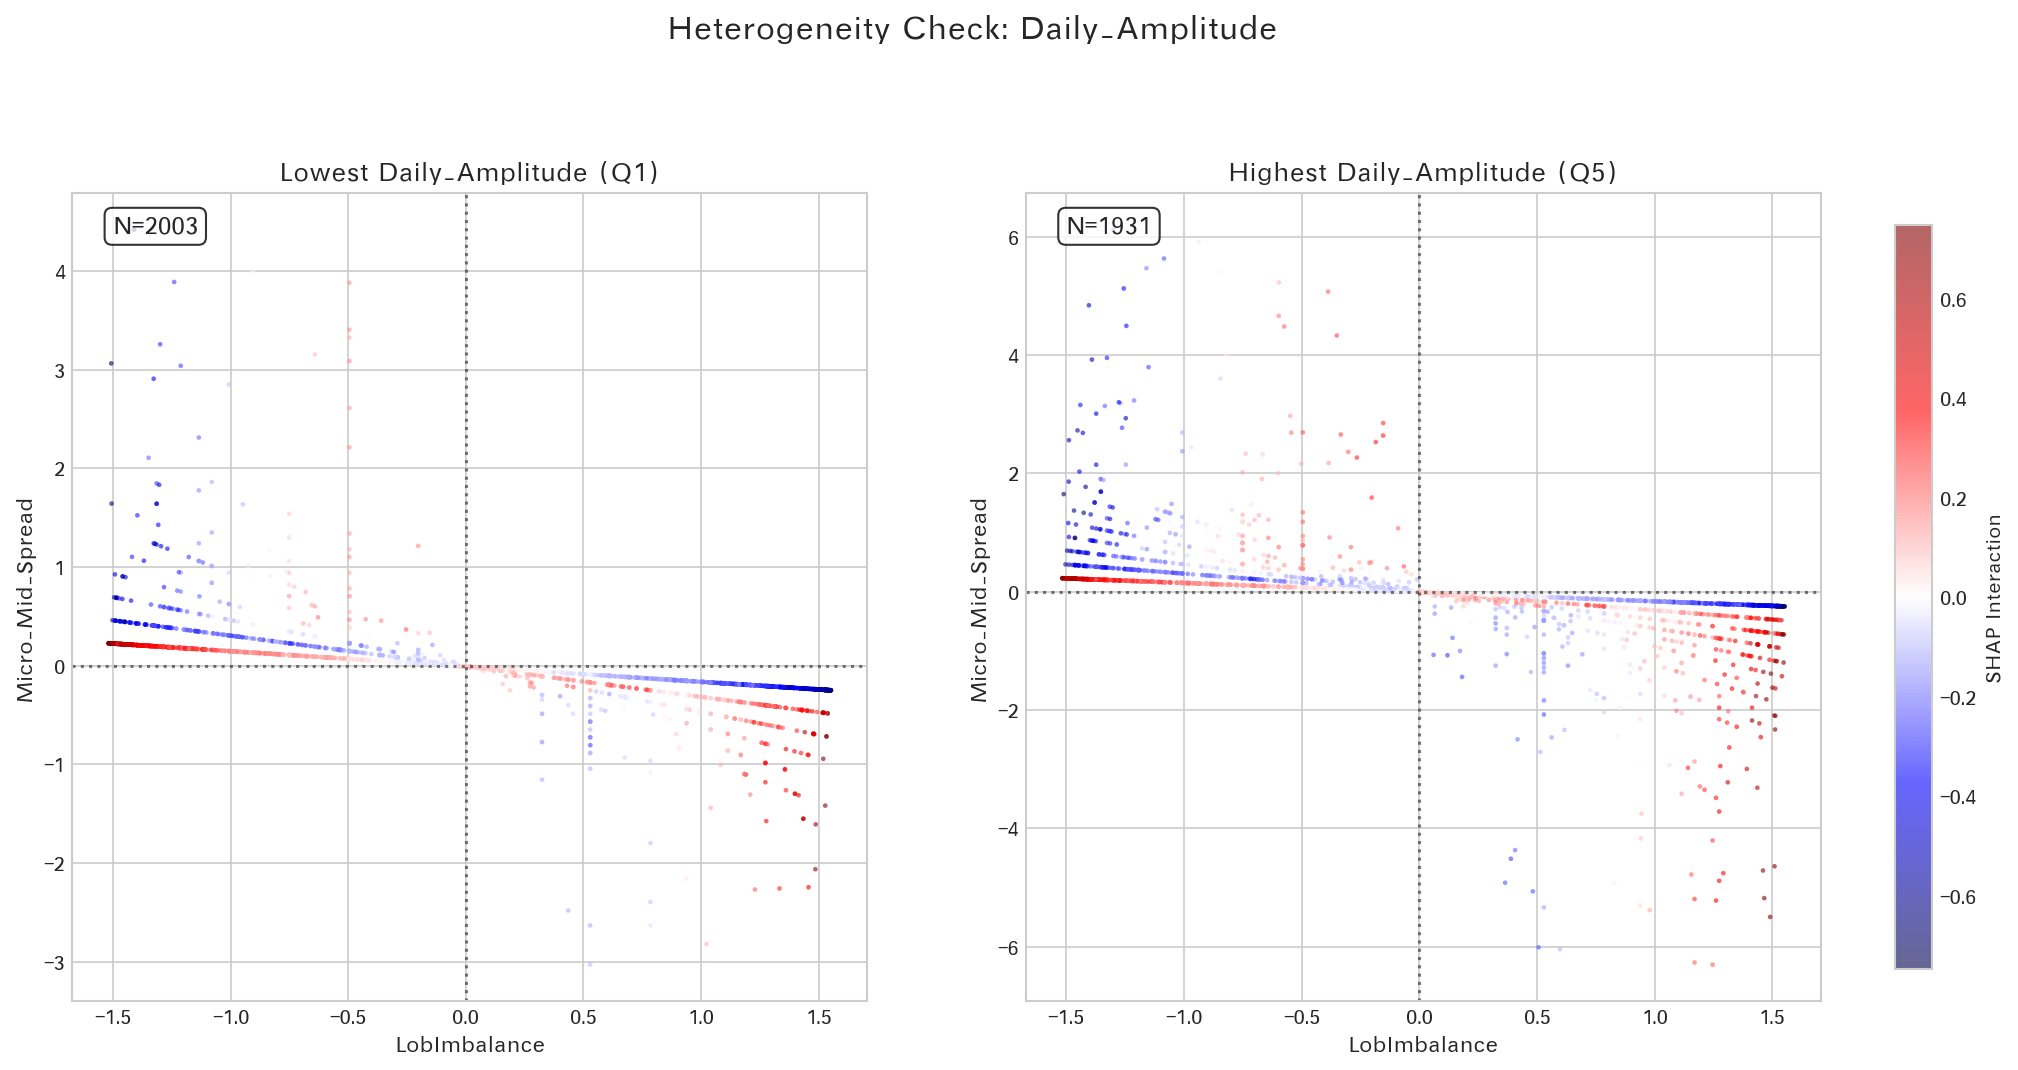


>>> Checking Factor: Daily_FloatMV ...
    Q1 (Low):  2003 | Max: 62203258986.0000
    Q5 (High): 1934 | Min: 240714342500.0000


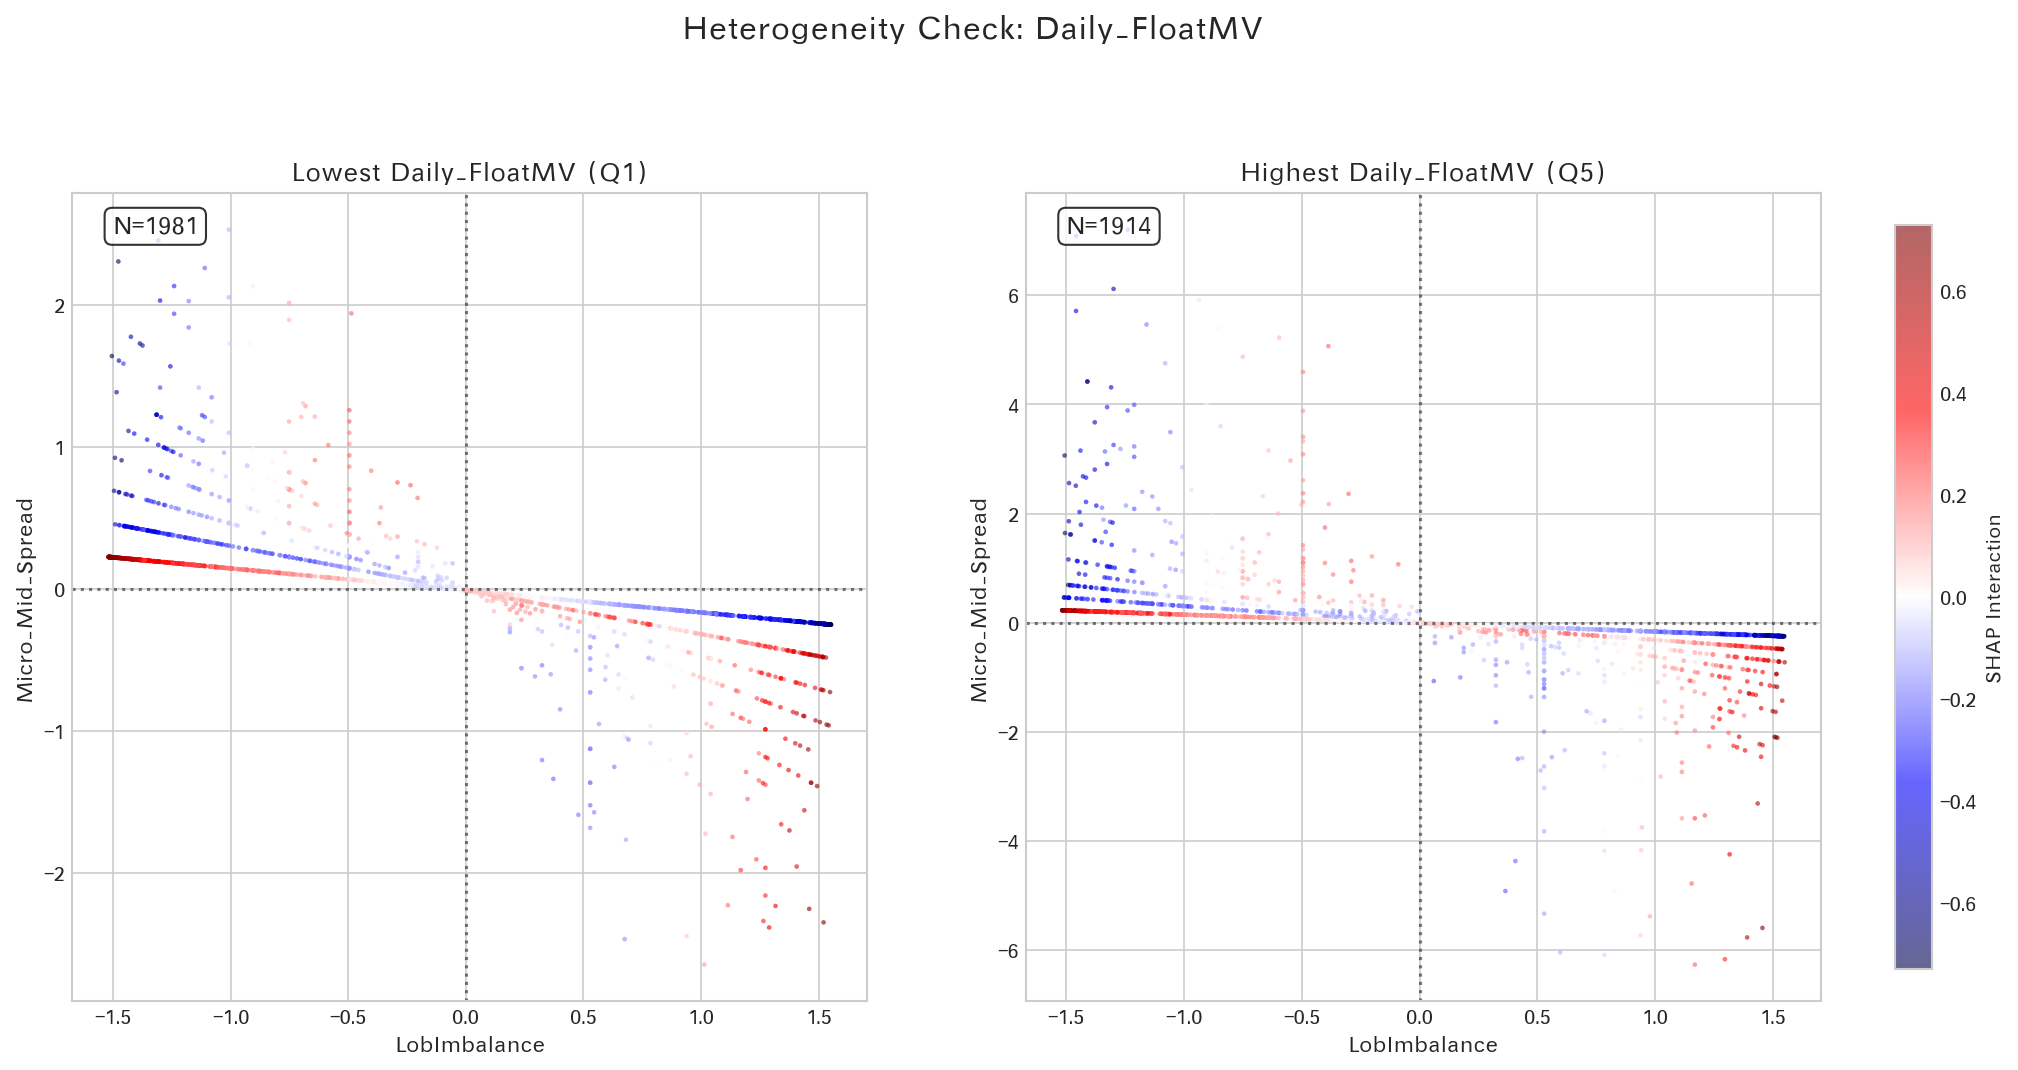


>>> Checking Factor: Daily_PE ...
    Q1 (Low):  1989 | Max: 12.6900
    Q5 (High): 1977 | Min: 60.4300


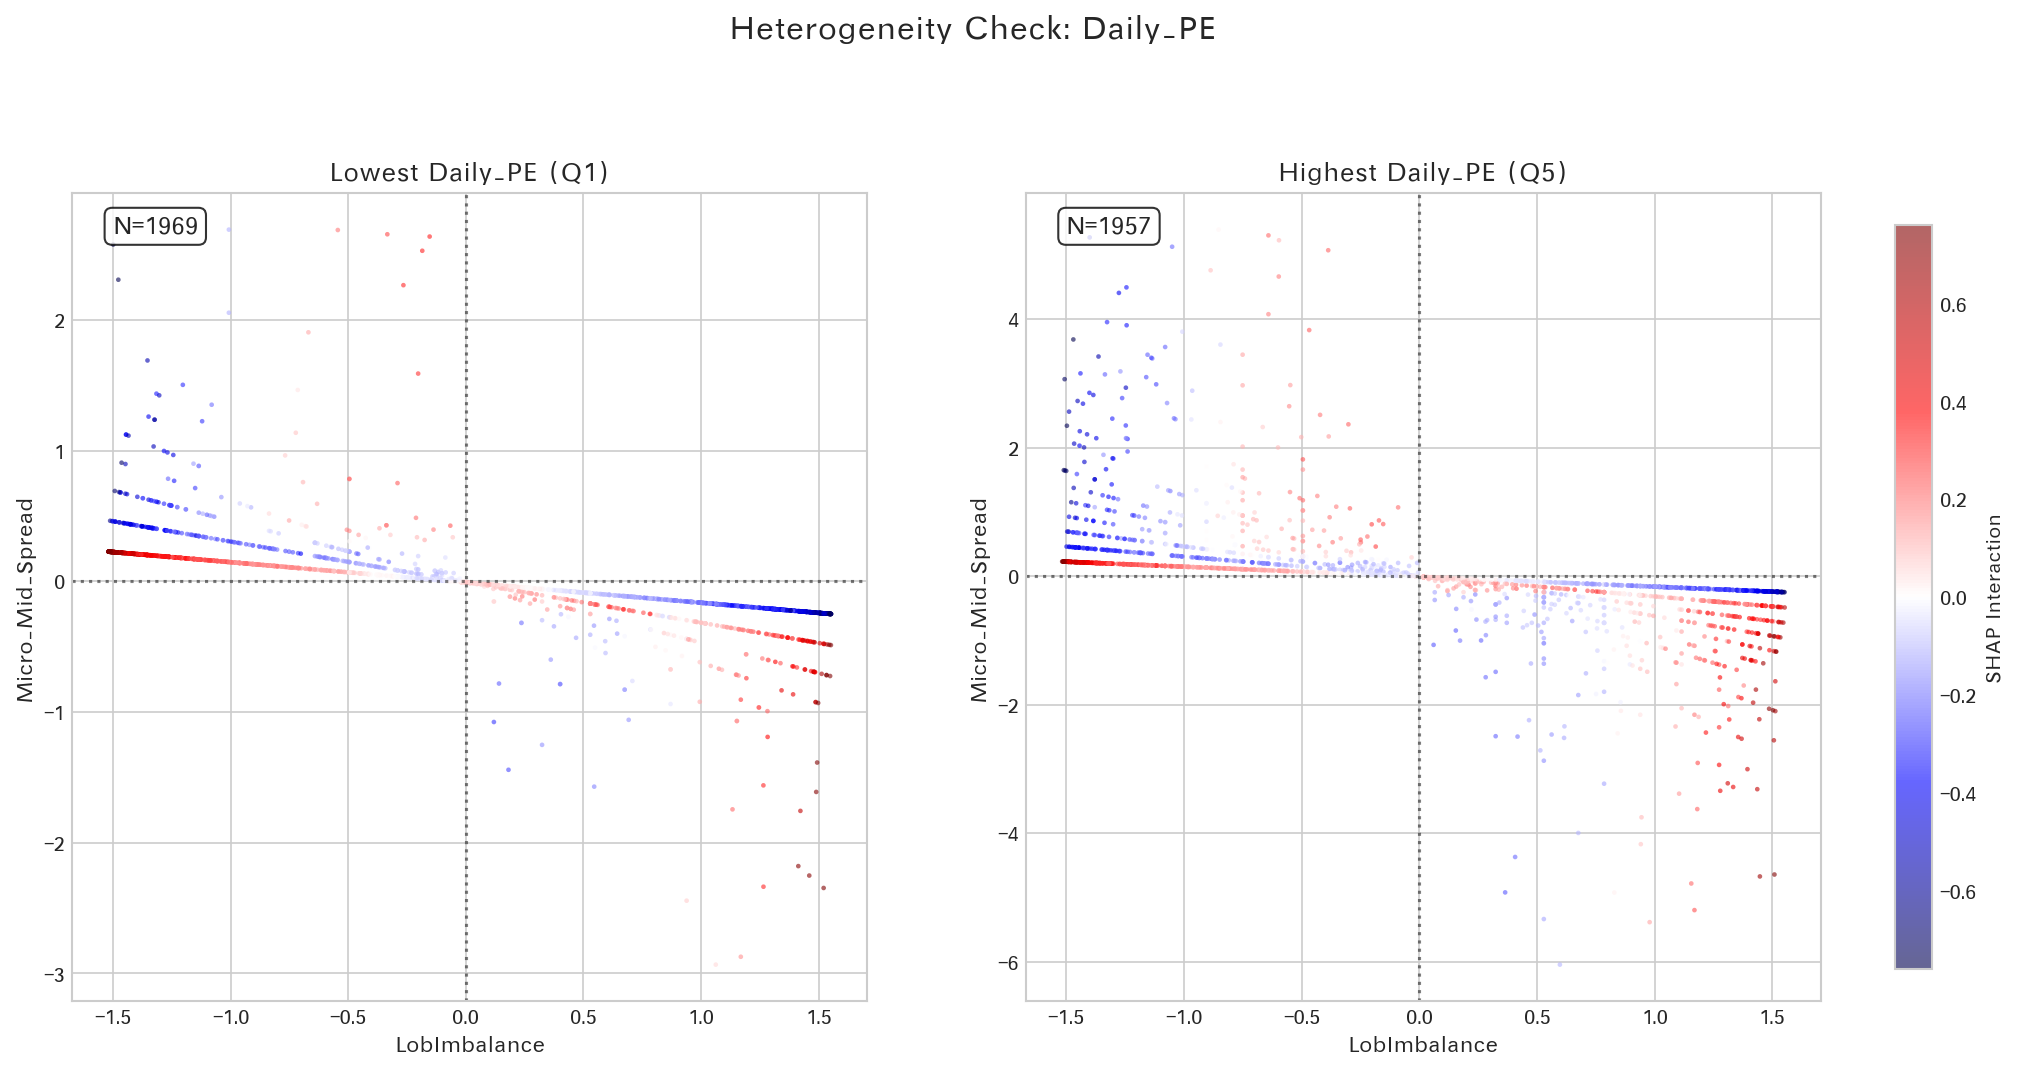


>>> Checking Factor: Daily_Price ...
    Q1 (Low):  2033 | Max: 19.8025
    Q5 (High): 1920 | Min: 124.0640


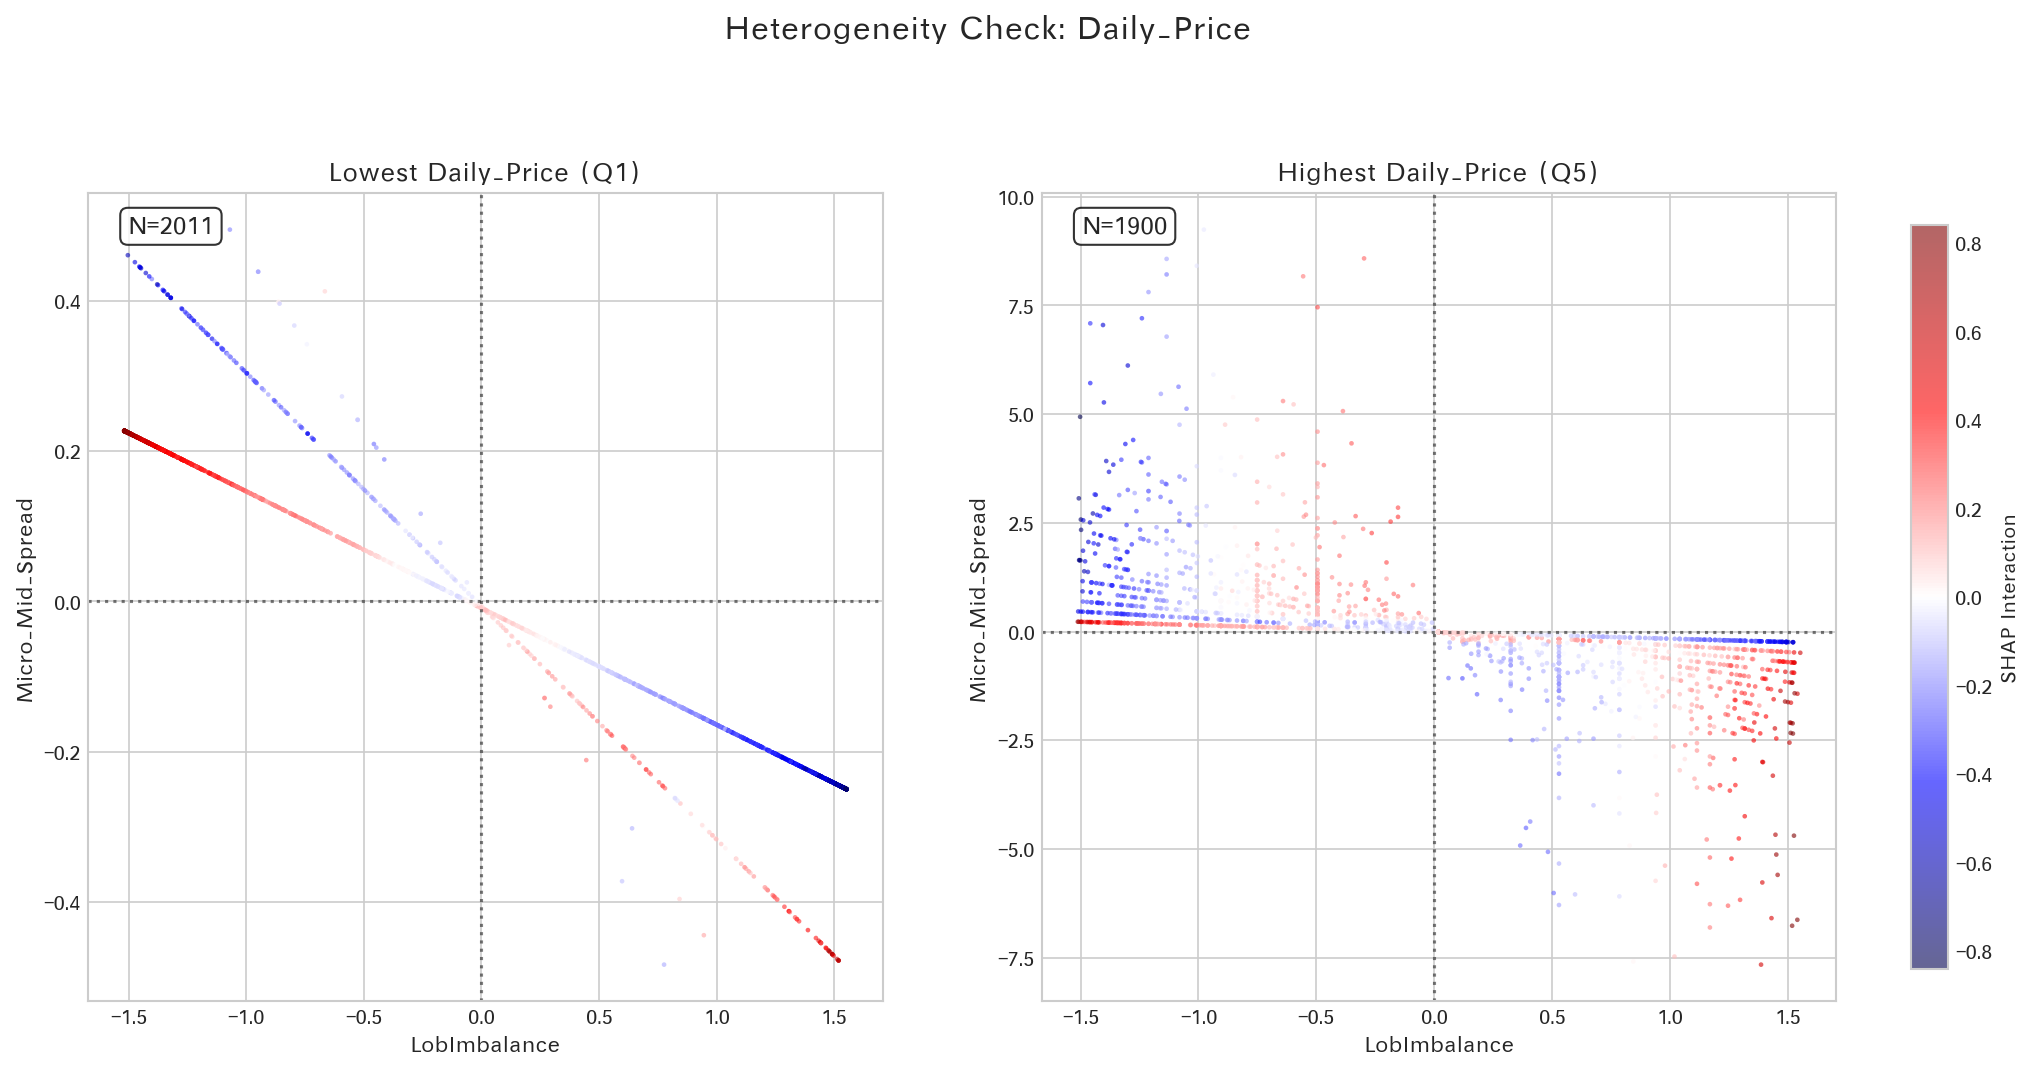


>>> Checking Factor: Daily_Turnover ...
    Q1 (Low):  2024 | Max: 0.5390
    Q5 (High): 1971 | Min: 2.4330


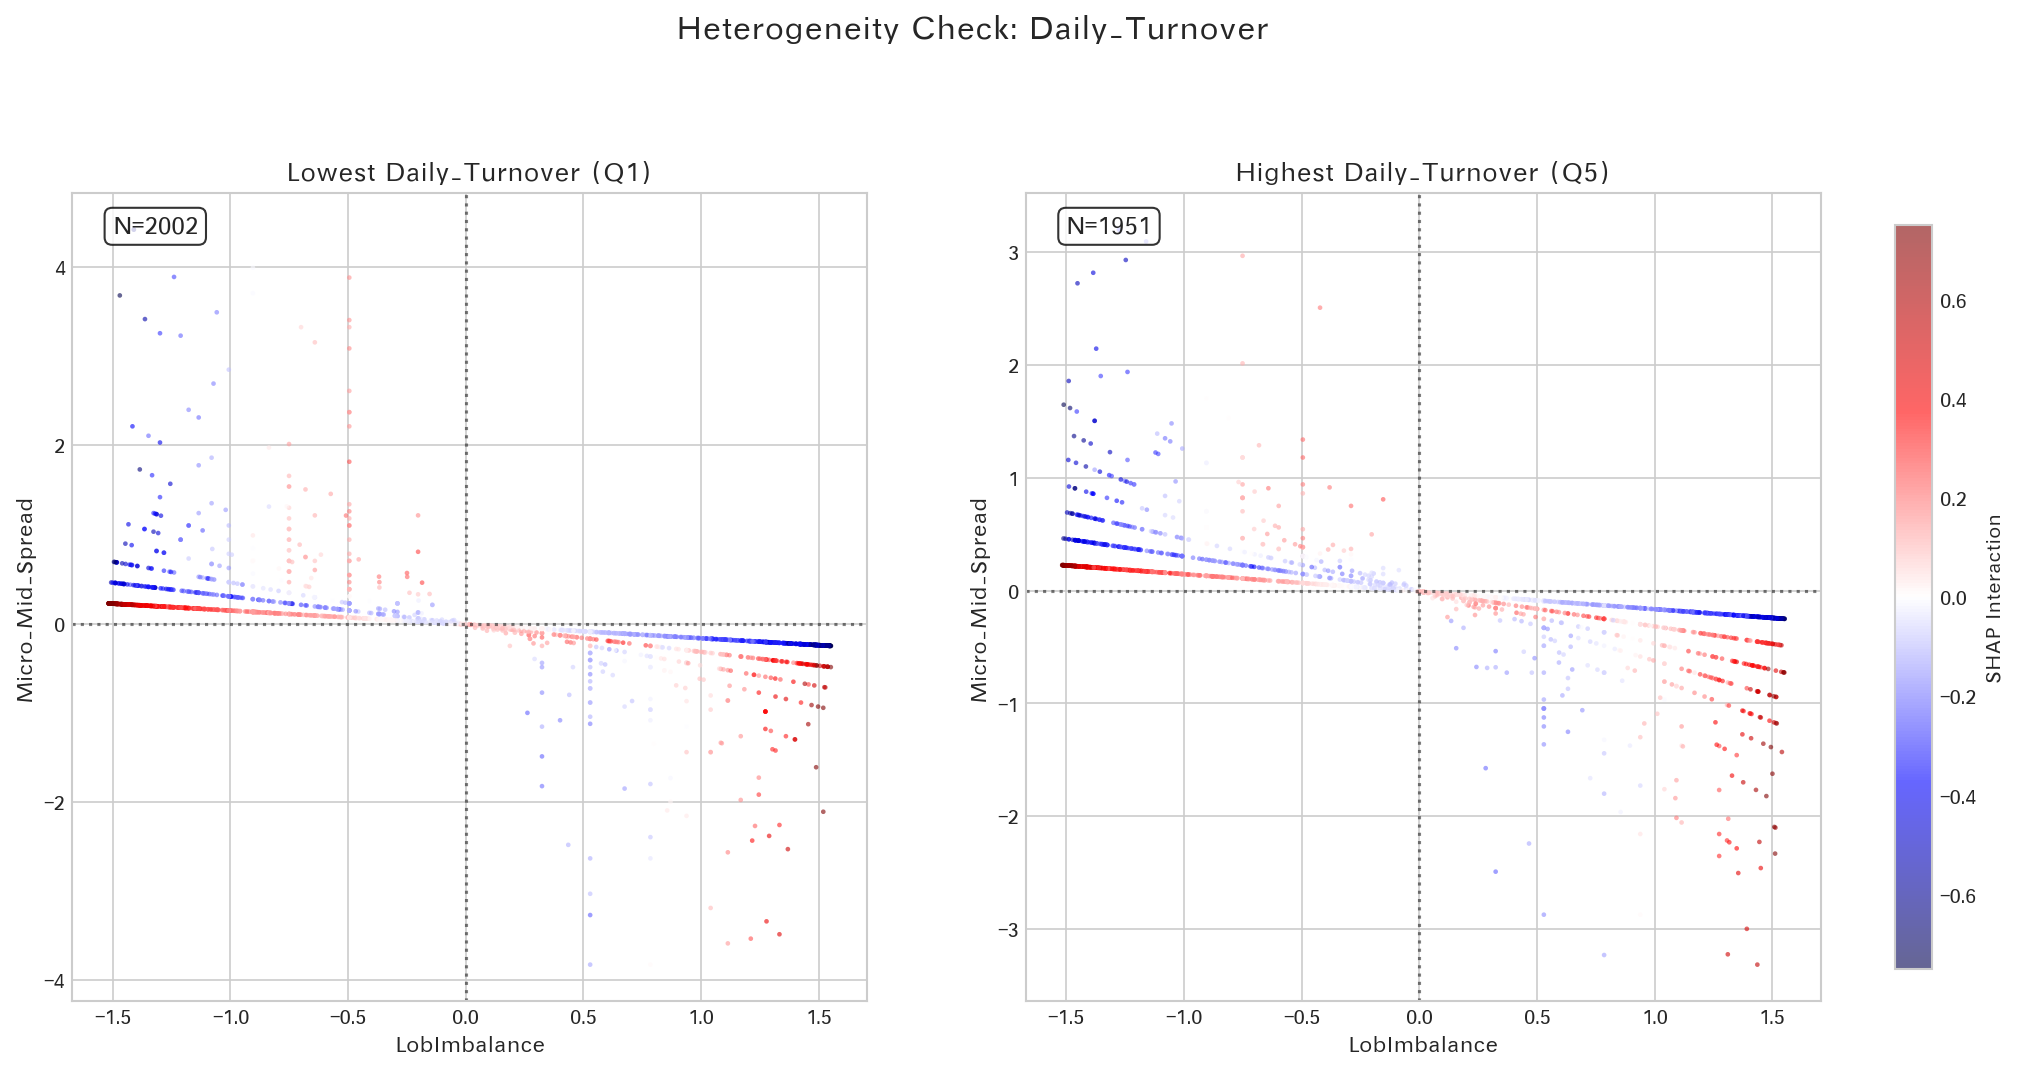


✅ 全量异质性检验完成。


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import datetime

# ================= 配置 =================
DPI = 150
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Hei', 'SimHei', 'Arial Unicode MS', 'DejaVu Sans'] 
plt.rcParams['axes.unicode_minus'] = False

# 自动定位路径
def find_project_root(current_path, marker='results'):
    current_path = os.path.abspath(current_path)
    if os.path.exists(os.path.join(current_path, marker)): return current_path
    parent = os.path.dirname(current_path)
    if parent == current_path: raise FileNotFoundError()
    return find_project_root(parent, marker)

try:
    PROJECT_ROOT = find_project_root(os.getcwd())
except:
    PROJECT_ROOT = '/Users/day/Desktop/书架/大三上/LOB_Spread_Regime'

DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'sample_with_time.parquet')
SHAP_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'sample_with_time_shap.npy')
# 读取新的特征文件
FEATURE_FILE = os.path.join(PROJECT_ROOT, 'data', 'processed', 'stock_heterogeneity_features.csv')

FEATURE_COLS = [
    'Accum_Vol_Diff', 'VolumeMax', 'VolumeAll', 'Immediacy', 
    'Depth_Change', 'LobImbalance', 'DeepLobImbalance', 
    'Relative_Spread', 'Micro_Mid_Spread', 'PastReturn', 
    'Lambda', 'Volatility', 'AutoCov'
]

# ================= 1. 加载数据 =================
print(">>> Loading SHAP Data...")
df = pd.read_parquet(DATA_PATH)
shap_values_all = np.load(SHAP_PATH)
idx_x = FEATURE_COLS.index('LobImbalance')
idx_y = FEATURE_COLS.index('Micro_Mid_Spread')
df['SHAP_Interaction'] = shap_values_all[:, idx_x, idx_y] * 2

print(">>> Loading Heterogeneity Features...")
if not os.path.exists(FEATURE_FILE):
    raise FileNotFoundError(f"Missing feature file: {FEATURE_FILE}")

df_features = pd.read_csv(FEATURE_FILE, dtype={'Stock': str})
print(f"    Features found: {df_features.columns.tolist()}")

# 合并
df['Stock'] = df['Stock'].astype(str).str.zfill(6)
df_features['Stock'] = df_features['Stock'].astype(str).str.zfill(6)
df_merged = pd.merge(df, df_features, on='Stock', how='inner')
print(f"    Merged Samples: {len(df_merged)}")

# ================= 2. 绘图函数 (Q1 vs Q5) =================
def plot_quintile_comparison(df_q1, df_q5, factor_name):
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), dpi=DPI)
    
    # 统一颜色刻度
    all_shap = np.concatenate([df_q1['SHAP_Interaction'], df_q5['SHAP_Interaction']])
    c_max = np.percentile(np.abs(all_shap), 98)
    
    datasets = [
        (df_q1, axes[0], f"Lowest {factor_name} (Q1)"), 
        (df_q5, axes[1], f"Highest {factor_name} (Q5)")
    ]
    
    for sub_df, ax, title in datasets:
        # 去极值 (Micro_Mid_Spread 1%)
        col_name = 'Micro_Mid_Spread'
        lb = sub_df[col_name].quantile(0.005)
        ub = sub_df[col_name].quantile(0.995)
        mask = (sub_df[col_name] >= lb) & (sub_df[col_name] <= ub)
        plot_df = sub_df[mask]
        
        sc = ax.scatter(
            x=plot_df['LobImbalance'], 
            y=plot_df['Micro_Mid_Spread'], 
            c=plot_df['SHAP_Interaction'], 
            cmap='seismic', 
            s=5, alpha=0.6,
            vmin=-c_max, vmax=c_max,
            edgecolor='none'
        )
        
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.set_xlabel('LobImbalance', fontsize=11)
        ax.set_ylabel('Micro_Mid_Spread', fontsize=11)
        ax.axhline(0, c='black', ls=':', alpha=0.5)
        ax.axvline(0, c='black', ls=':', alpha=0.5)
        ax.text(0.05, 0.95, f"N={len(plot_df)}", transform=ax.transAxes, 
                fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('SHAP Interaction', fontsize=10)
    plt.suptitle(f"Heterogeneity Check: {factor_name}", fontsize=16, y=1.05)
    plt.show()

# ================= 3. 执行全量检验 =================
# 定义 09 程序关注的所有 5 个指标
target_factors = [
    'Daily_Amplitude',   # 振幅
    'Daily_FloatMV',     # 流通市值
    'Daily_PE',          # 市盈率
    'Daily_Price',       # 股价
    'Daily_Turnover'     # 换手率
]

for factor in target_factors:
    if factor not in df_merged.columns:
        print(f"⚠️ 跳过 {factor}: 列不存在")
        continue
        
    print(f"\n>>> Checking Factor: {factor} ...")
    valid_df = df_merged.dropna(subset=[factor]).copy()
    
    try:
        # 五分位切分
        valid_df['Group'] = pd.qcut(valid_df[factor], q=5, labels=['Q1','Q2','Q3','Q4','Q5'])
        
        df_q1 = valid_df[valid_df['Group'] == 'Q1']
        df_q5 = valid_df[valid_df['Group'] == 'Q5']
        
        print(f"    Q1 (Low):  {len(df_q1)} | Max: {valid_df[valid_df['Group']=='Q1'][factor].max():.4f}")
        print(f"    Q5 (High): {len(df_q5)} | Min: {valid_df[valid_df['Group']=='Q5'][factor].min():.4f}")
        
        plot_quintile_comparison(df_q1, df_q5, factor)
        
    except Exception as e:
        print(f"    Error: {e}")

print("\n✅ 全量异质性检验完成。")